# Removing gender bias when predicting salary of employees

## Salary of Louisville Metro Government employees
### The data set is used to train a model to predict the salary of employees. XGBoost is used to train the model.
#### It is observed that the vannila model predicts with a gender bias
#### Feature importance is performed using SHAPLEY and the gender biased value is removed from the model
#### After that the model is seen to predict equally for male and female employees without gender bias

##### Data source https://catalog.data.gov/dataset/employee-salary-data
##### This tutorial is referred in implementing this https://towardsdatascience.com/preventing-machine-learning-bias-d01adfe9f1fa

# Import required libraries

In [127]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

In [128]:
import gender_guesser.detector as gender

In [129]:
import xgboost as xgb
from xgboost import DMatrix
from sklearn.model_selection import train_test_split

In [134]:
#!pip install gender_guesser
#!pip install xgboost

In [135]:
os.chdir('D:\PhD\Spring2022\MIS_Research_Seminar\Assignment\EthicalAI')

# Read the data

In [136]:
salary = pd.read_csv('SalaryData.csv')

In [137]:
salary.head()

,CalYear,Employee_Name,Department,jobTitle,Annual_Rate,Regular_Rate,Overtime_Rate,Incentive_Allowance,Other,YTD_Total
0,2020,NaN,Parks & Recreation,Park Worker II-CDL,33321.6,1249.56,0.0,0.0,0.0,1249.56
1,2020,NaN,Parks & Recreation,Recreation Instructor,22880.0,569.25,0.0,0.0,0.0,569.25
2,2020,NaN,Parks & Recreation,Recreation Aide,21840.0,152.25,0.0,0.0,0.0,152.25
3,2020,NaN,Human Services,Staff Helper/Internal,21008.0,333.30,0.0,0.0,0.0,333.30
4,2020,NaN,Parks & Recreation,Recreation Aide,21840.0,152.25,0.0,0.0,0.0,152.25


In [138]:
salary = salary.fillna('Paul')

### Since the gender column is not present in the dataset, gender is guessed by using the name

In [139]:
# https://pypi.org/project/gender-guesser/
d = gender.Detector()

In [140]:
def find_gender(x):
    return(d.get_gender(x))


In [141]:
salary['gender'] = salary['Employee_Name'].apply(lambda x: find_gender(x.split(',')[1].strip()) if len(x.split(',')) > 1 else find_gender(x))

In [142]:
salary.head()

,CalYear,Employee_Name,Department,jobTitle,Annual_Rate,Regular_Rate,Overtime_Rate,Incentive_Allowance,Other,YTD_Total,gender
0,2020,Paul,Parks & Recreation,Park Worker II-CDL,33321.6,1249.56,0.0,0.0,0.0,1249.56,male
1,2020,Paul,Parks & Recreation,Recreation Instructor,22880.0,569.25,0.0,0.0,0.0,569.25,male
2,2020,Paul,Parks & Recreation,Recreation Aide,21840.0,152.25,0.0,0.0,0.0,152.25,male
3,2020,Paul,Human Services,Staff Helper/Internal,21008.0,333.30,0.0,0.0,0.0,333.30,male
4,2020,Paul,Parks & Recreation,Recreation Aide,21840.0,152.25,0.0,0.0,0.0,152.25,male


In [143]:
salary['gender'].value_counts()

male             26194
female           13448
unknown           3946
mostly_female     2242
mostly_male       1680
andy               278
Name: gender, dtype: int64

### The number of genders is reduced to 'male' and 'female' 
#### This is done by overriding 'unknown' to a randomly selected 'male' or 'female'. Similarly, 'mostly_male' is overridden to 'male' and 'mostly_female' is overridden to 'female' and 'andy' type is overrideen with a random choice again

In [144]:
def update_gender(x):
    if x == 'unknown':
        x = random.choice(['male', 'female'])
    elif x == 'mostly_female':
        x = random.choice(['male', 'female'])
    elif x == 'mostly_male':
        x = 'male'
    elif x == 'male':
        x = 'male'
    elif x == 'female':
        x = 'female'
    else:
        x = random.choice(['male', 'female'])
    
        
    return(x)

In [145]:
salary['gender_1'] = salary['gender'].apply(lambda x: update_gender(x))

In [146]:
salary['gender_1'].value_counts()

male      31159
female    16629
Name: gender_1, dtype: int64

In [147]:
salary['gender_1'] = pd.Categorical(salary['gender_1'])
salary['jobTitle'] = pd.Categorical(salary['jobTitle'])
salary['Department'] = pd.Categorical(salary['Department'])


In [148]:
salary.columns

Index(['CalYear', 'Employee_Name', 'Department', 'jobTitle', 'Annual_Rate',
       'Regular_Rate', 'Overtime_Rate', 'Incentive_Allowance', 'Other',
       'YTD_Total', 'gender', 'gender_1'],
      dtype='object')

# Train an XGBoost model

### Select the columns 'gender', 'jobTitle' and 'Department' as X (features)
### Select 'YTD_Total' as y (label column)

In [149]:
X = salary[['gender_1', 'jobTitle', 'Department']]
y = salary['YTD_Total']

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1500)

### Split the data into Train and Test data sets

In [151]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33451, 3), (14337, 3), (33451,), (14337,))

In [152]:
dtrain = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(data = X_test, label=y_test, enable_categorical=True)

In [153]:
param = {'eta': 0.1, 'objective': 'reg:linear'}

### Train the model and predict using test dataset

In [154]:
xgb_model = xgb.train(param, dtrain, num_boost_round=100) 

[19:07:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [155]:
X_test['y_hat_with_bias'] = xgb_model.predict(dtest)

C:\Users\sks4w\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [156]:
X_test.head()

,gender_1,jobTitle,Department,y_hat_with_bias
10036,female,Secretary - A/U U315,Youth Detention Services,31297.367188
11110,female,Traffic Guard III,Louisville Metro Police,20620.271484
22920,female,Police Officer,Louisville Metro Police,58130.964844
42986,male,Workforce Solutions Manager,Economic Development,43551.375000
39538,male,Police Recruit,Louisville Metro Police,16715.191406


In [157]:
X_test['jobTitle'].value_counts().to_csv('jobTitle_counts.csv')

In [158]:
X_test[X_test['jobTitle']=='Police Officer'].groupby('gender_1').mean('y_hat_with_bias')

,y_hat_with_bias
gender_1,
female,58130.964844
male,60703.667969


# Implement a method to remove gender bias

### In XGBoost, Shapley Additive Explanation method provides a deterministic method for extracting feature contributions at the individual prediction level

### The contribution of gender is captured and that contribution is deducted from the predicted values to remove the bias

In [159]:
feature_names = dtest.feature_names

In [160]:
interactions = xgb_model.predict(dtest, pred_interactions=True)

In [161]:
pd.DataFrame(interactions[0], index = feature_names + ['intercept'], columns = feature_names + ['intercept'])

,gender_1,jobTitle,Department,intercept
gender_1,-178.084045,-2282.174072,-195.159851,0.000000
jobTitle,-2282.178467,-6431.643555,-1290.439453,0.000000
Department,-195.160217,-1290.440674,1880.913696,0.000000
intercept,0.000000,0.000000,0.000000,43561.742188


In [162]:
bias_var = np.array('gender_1')
bias_idx = np.argwhere(np.isin(np.array(feature_names), bias_var))[0]

In [163]:
interactions[:, bias_idx, :] = 0
interactions[:, :, bias_idx] = 0

In [164]:
y_hat_no_bias = interactions.sum(axis = 1).sum(axis = 1)

In [165]:
len(y_hat_no_bias)

14337

In [166]:
len(X_test['y_hat_with_bias'])

14337

In [167]:
X_test['y_hat_no_bias'] = y_hat_no_bias

C:\Users\sks4w\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Predicted values after removing bias
### For some of the job titles the comparison is shown below

In [171]:
X_test[X_test['jobTitle']=='Police Officer'].groupby('gender_1').mean('y_hat_no_bias')

,y_hat_with_bias,y_hat_no_bias
gender_1,,
female,58130.964844,59842.296875
male,60703.667969,59770.289062


In [172]:
X_test[X_test['jobTitle']=='Corrections Officer'].groupby('gender_1').mean('y_hat_no_bias')

,y_hat_with_bias,y_hat_no_bias
gender_1,,
female,40783.855469,42716.511719
male,43539.757812,42491.855469


In [173]:
X_test[X_test['jobTitle']=='Firefighter 56 Hr'].groupby('gender_1').mean('y_hat_no_bias')

,y_hat_with_bias,y_hat_no_bias
gender_1,,
female,53308.636719,56415.812500
male,58077.234375,56435.414062


In [174]:
X_test[X_test['jobTitle']=='Police Sergeant'].groupby('gender_1').mean('y_hat_no_bias')

,y_hat_with_bias,y_hat_no_bias
gender_1,,
female,76020.046875,77095.531250
male,77803.070312,76964.851562


In [175]:
X_test[X_test['jobTitle']=='EMT'].groupby('gender_1').mean('y_hat_no_bias')

,y_hat_with_bias,y_hat_no_bias
gender_1,,
female,35651.628906,36956.687500
male,37315.187500,36652.925781


In [176]:
X_test[X_test['jobTitle']=='Fire Company Commander 56 Hr'].groupby('gender_1').mean('y_hat_no_bias')

,y_hat_with_bias,y_hat_no_bias
gender_1,,
female,71113.515625,73983.226562
male,76306.242188,74177.523438


In [177]:
X_test[X_test['jobTitle']=='Recreation Aide'].groupby('gender_1').mean('y_hat_no_bias')

,y_hat_with_bias,y_hat_no_bias
gender_1,,
female,4917.475586,4773.339844
male,4369.423340,4420.726562


In [178]:
X_test[X_test['jobTitle']=='Library Clerk L/U'].groupby('gender_1').mean('y_hat_no_bias')

,y_hat_with_bias,y_hat_no_bias
gender_1,,
female,19237.091797,20760.005859
male,21487.900391,20664.554688


In [179]:
X_test[X_test['jobTitle']=='Library Assistant L/U'].groupby('gender_1').mean('y_hat_no_bias')

,y_hat_with_bias,y_hat_no_bias
gender_1,,
female,27402.746094,28546.376953
male,29128.750000,28506.652344


In [180]:
X_test[X_test['jobTitle']=='Fire Apparatus Operator 56 Hr'].groupby('gender_1').mean('y_hat_no_bias')

,y_hat_with_bias,y_hat_no_bias
gender_1,,
female,63298.800781,67449.007812
male,69846.210938,67650.968750


In [182]:
jobTitles = ['Police Officer', 'Corrections Officer', 'Police Sergeant', 'Fire Company Commander 56 Hr', 'Fire Apparatus Operator 56 Hr']
predicted_sal_with_bias_female = [57615, 40516, 75267, 72640, 63317]
predicted_sal_with_bias_male = [60764, 43472, 77976, 75694, 69486]
predicted_sal_no_bias_female = [59768, 42395, 76993, 73619,  67233]
predicted_sal_no_bias_male = [59706, 42398, 76926, 73772, 67386]



# The comparitive graph below shows the prediction before and after bias removal 

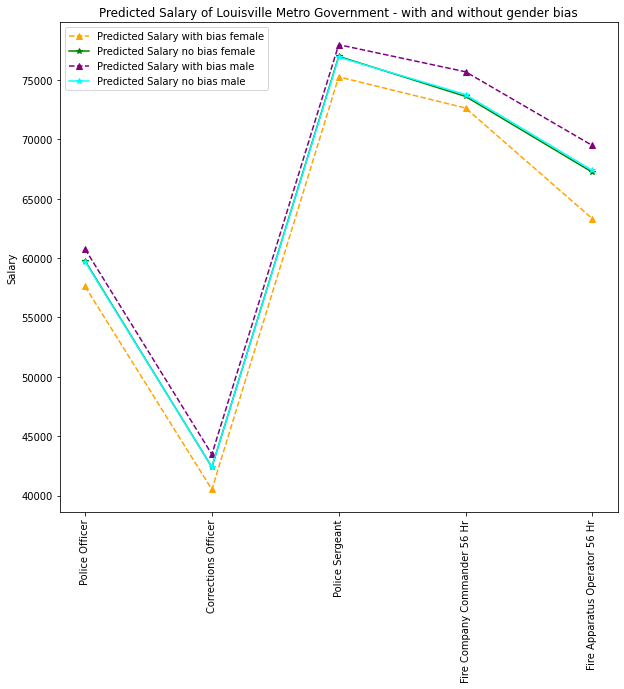

In [186]:
# https://stackoverflow.com/questions/19125722/adding-a-legend-to-pyplot-in-matplotlib-in-the-simplest-manner-possible
plt.plot(jobTitles, predicted_sal_with_bias_female, color='orange', label = 'Predicted Salary with bias female', marker='^', linestyle='--')
plt.plot(jobTitles, predicted_sal_no_bias_female, color='green', label = 'Predicted Salary no bias female', marker = '*')
plt.plot(jobTitles, predicted_sal_with_bias_male, color='purple', label = 'Predicted Salary with bias male', marker = '^', linestyle='--')
plt.plot(jobTitles, predicted_sal_no_bias_male, color='cyan', label = 'Predicted Salary no bias male', marker = '*')
plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [12,10]
plt.legend()
plt.ylabel('Salary')
plt.title('Predicted Salary of Louisville Metro Government - with and without gender bias')
plt.show()

# Conclusion
#### Therefore we can see that, as shown by the dotted lines in orange and purple, the predicted salary of male and female before removing bias were quite different. For male candidates, it was predicting higher salary than for female candidates. This is based on the real data of Louisville Metro Government.
#### After the bias is removed, as shown by the solid lines in green and cyan, the predicted salary of male and female almost overlap with each other.
#### It can be noted that, the predicted salary after removing bias is higher than the salary of female with bias, while at the same time, it is lower than the salary of male with bias
#### Hence, it is concluded that the gender bias is removed effectively from this model based on this sample of job titles verified 